In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
filepath='PJM_data\DEOK_hourly.csv'
DEOK_load=pd.read_csv(filepath)
DEOK_load.index = pd.to_datetime(DEOK_load['Datetime'], format='%m/%d/%Y')
DEOK_load = DEOK_load['MW']
DEOK_load.head()

Datetime
2012-01-01    2629.913043
2012-01-02    3179.875000
2012-01-03    3503.375000
2012-01-04    3470.541667
2012-01-05    3210.125000
Name: MW, dtype: float64

In [3]:
#read temperature data in Columbus, OH
OK_temp_df = pd.read_csv("PJM_data\DEOKweather.csv")

#set timestamp as index
OK_temp_df.index = pd.to_datetime(OK_temp_df['Datetime'], format='%m/%d/%Y')

OK_temp_df = OK_temp_df['TAVG']
OK_temp_df.head()

Datetime
2012-01-01    43.5
2012-01-02    26.0
2012-01-03    21.0
2012-01-04    28.5
2012-01-05    36.5
Name: TAVG, dtype: float64

In [4]:
df = pd.merge(DEOK_load, OK_temp_df, left_index=True, right_index=True)
df.head()

,MW,TAVG
Datetime,,
2012-01-01,2629.913043,43.5
2012-01-02,3179.875000,26.0
2012-01-03,3503.375000,21.0
2012-01-04,3470.541667,28.5
2012-01-05,3210.125000,36.5


In [5]:
df.tail()

,MW,TAVG
Datetime,,
2018-07-30,3359.333333,74.0
2018-07-31,3405.250000,74.0
2018-08-01,3345.375000,71.0
2018-08-02,3471.083333,72.0
2018-08-03,3281.000000,75.0


Text(0, 0.5, 'Energy (MW)')

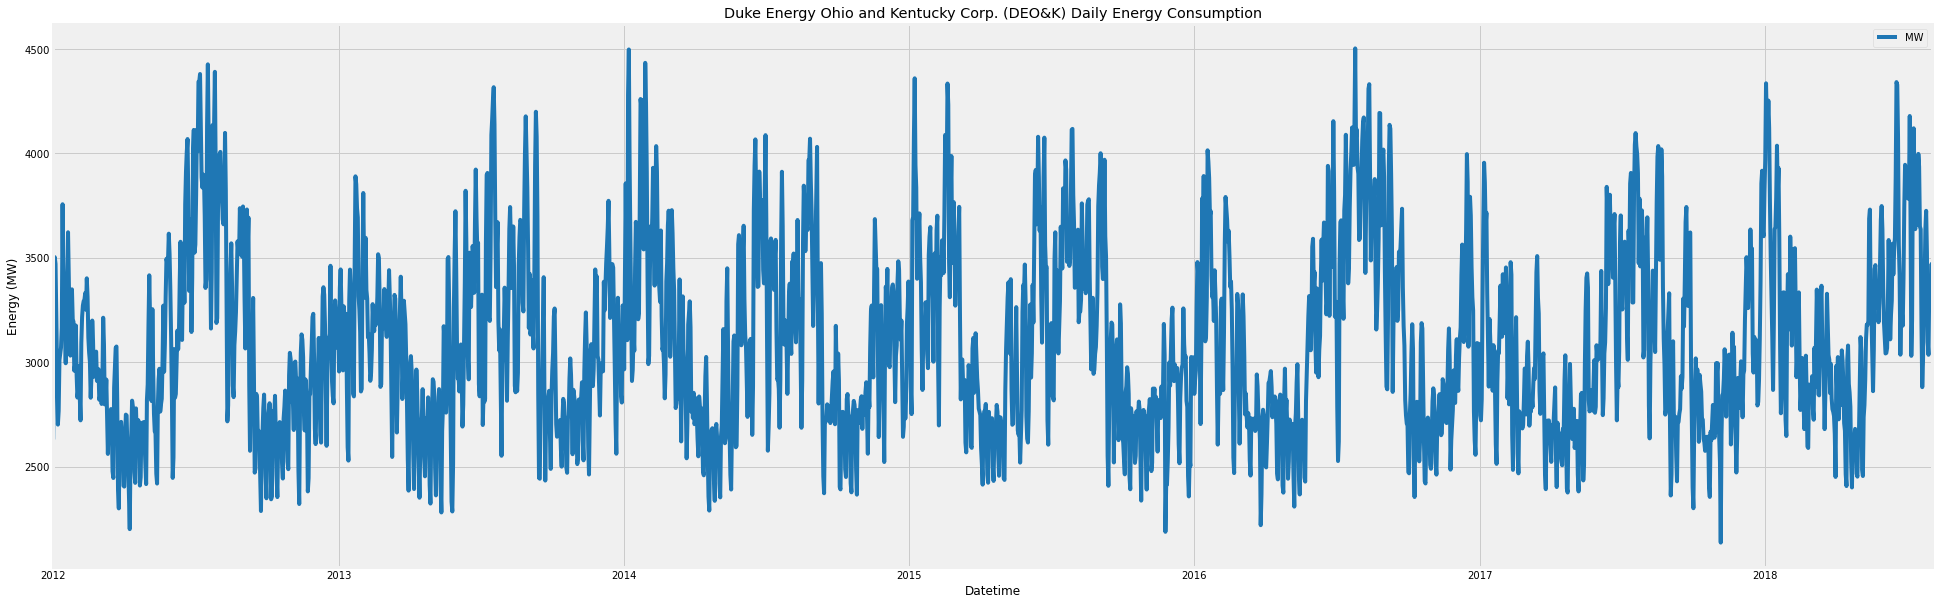

In [6]:
df.plot(y='MW', style='-',
        figsize=(30, 10),
        color=color_pal[0],
        title="Duke Energy Ohio and Kentucky Corp. (DEO&K) Daily Energy Consumption")
plt.ylabel("Energy (MW)")


Text(0, 0.5, 'Energy (MW)')

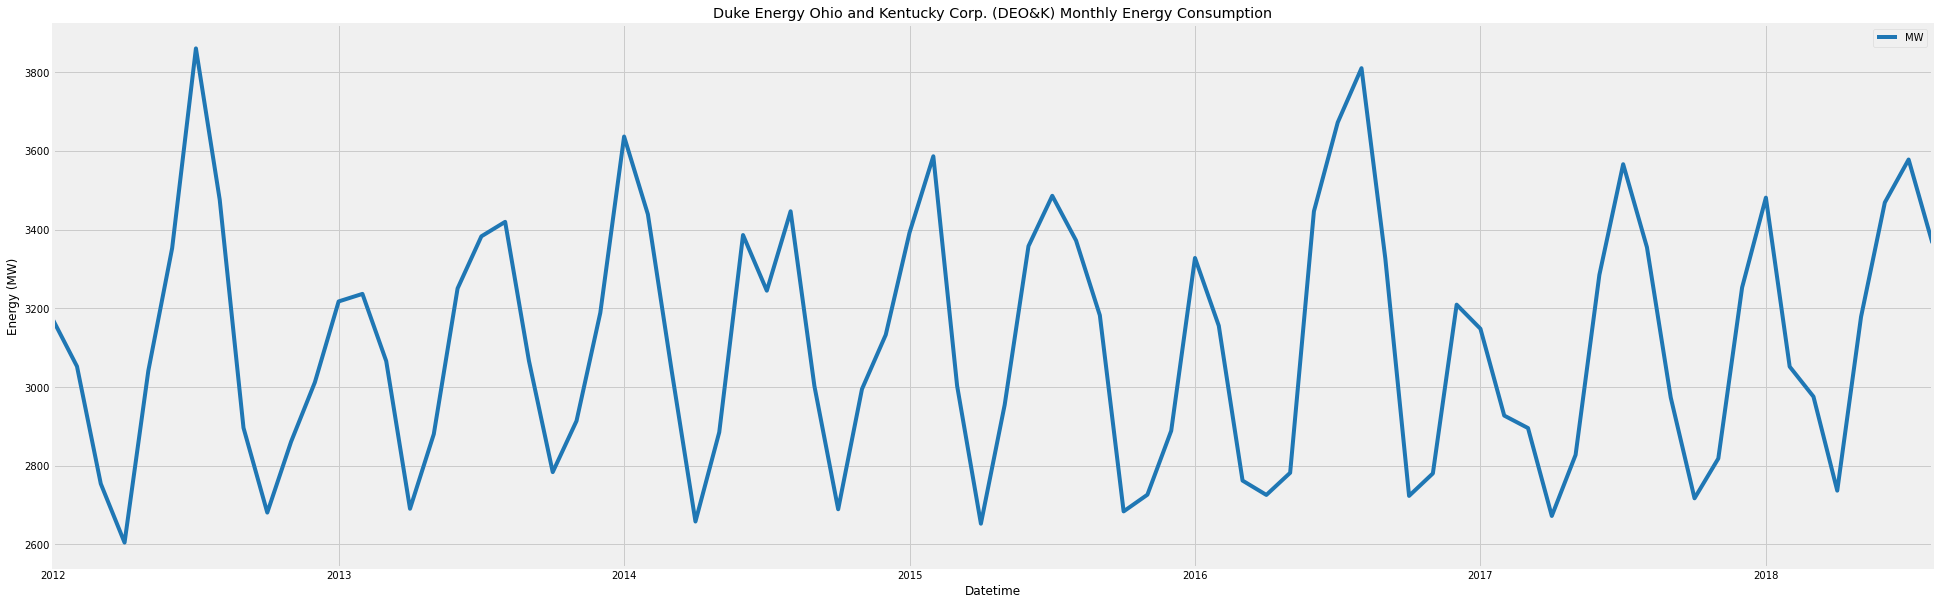

In [7]:
monthly_df = df.resample('1M').mean()
monthly_df1 = monthly_df
monthly_df.plot(y='MW', style='-',
        figsize=(30, 10),
        color=color_pal[0],
        title="Duke Energy Ohio and Kentucky Corp. (DEO&K) Monthly Energy Consumption")
plt.ylabel("Energy (MW)")



In [8]:
train = monthly_df.loc[monthly_df.index < '01-01-2017']
test = monthly_df.loc[monthly_df.index >= '01-01-2017']

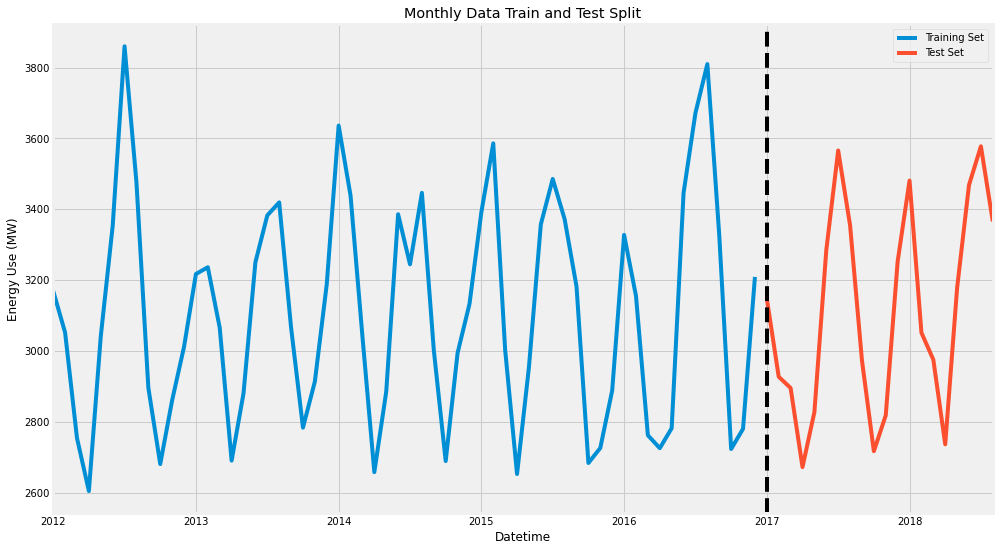

In [9]:
fig, ax = plt.subplots(figsize=(15, 9))
train.plot(y='MW', ax=ax, label= 'Training Set')
test.plot(y='MW', ax=ax, label = "Test Set")
ax.axvline('01-01-2017', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Monthly Data Train and Test Split')
ax.set_ylabel('Energy Use (MW)')
plt.show()

# ACF and PACF Graphs

<BarContainer object of 20 artists>

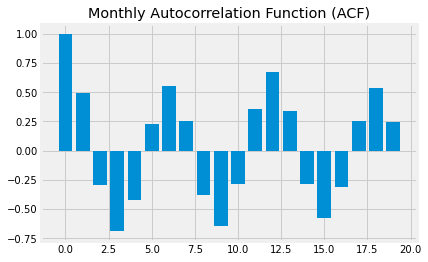

In [10]:
# plot the acf function on the ts_data_load_subset
acf_vals = acf(monthly_df['MW'])
num_lags = 20
plt.title('Monthly Autocorrelation Function (ACF)')
plt.bar(range(num_lags), acf_vals[:num_lags])


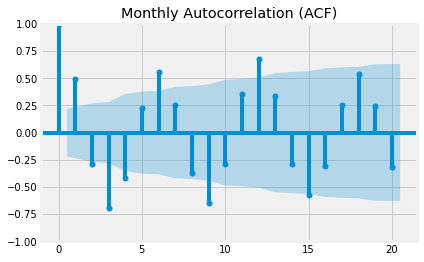

In [11]:
# Import plot_acf() function 
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load set
plot_acf(monthly_df['MW'])
plt.title('Monthly Autocorrelation (ACF)')
plt.show()


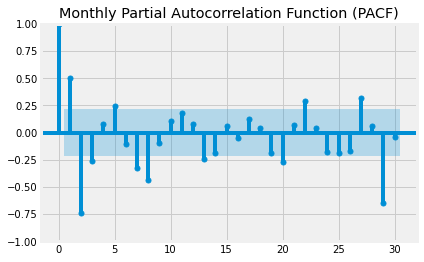

In [12]:
# import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# plot the pacf function on the monthly dataset
plot_pacf(monthly_df['MW'], lags=30)
plt.title('Monthly Partial Autocorrelation Function (PACF)')
plt.show() 

# Augmented Dickey-Fuller Test

In [13]:
ad_fuller_result = adfuller(monthly_df['MW'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.793471296999545
p-value: 4.811914924195606e-07


# Feature Creation

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

monthly_df = create_features(monthly_df)

# Visualize our Feature / Target Relationship

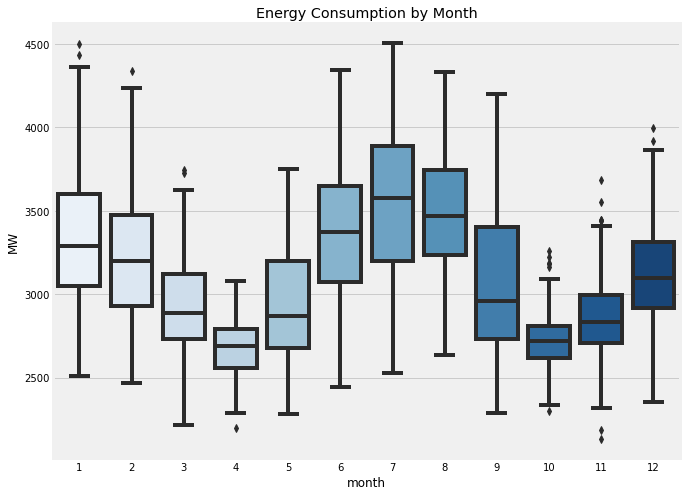

In [15]:
df = create_features(df)
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='MW', palette='Blues')
ax.set_title('Energy Consumption by Month')
plt.show()

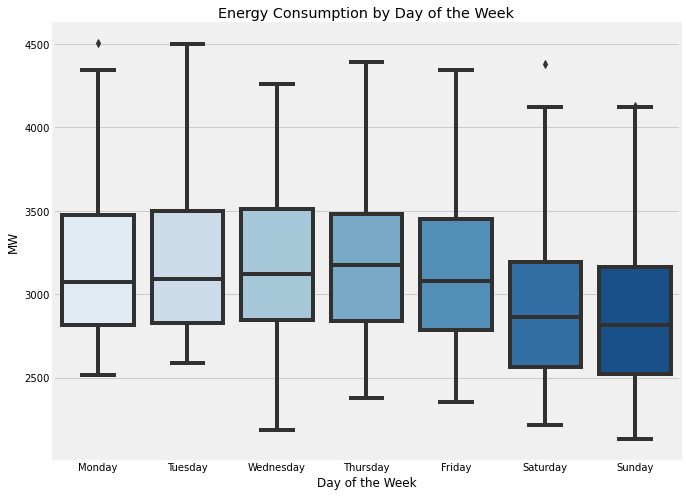

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='MW', palette='Blues')
ax.set_title('Energy Consumption by Day of the Week')
ticks = list(range(0, 7))
labels = "Monday Tuesday Wednesday Thursday Friday Saturday Sunday".split()
plt.xticks(ticks, labels)
plt.xlabel('Day of the Week')
plt.show()

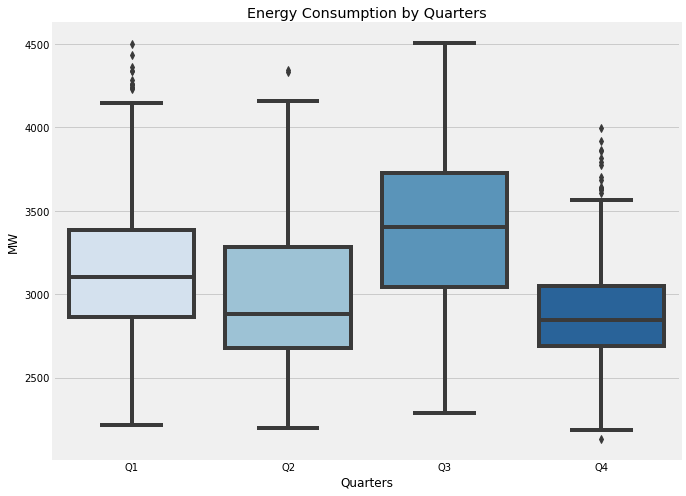

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='MW', palette='Blues')
ax.set_title('Energy Consumption by Quarters')
ticks = list(range(0, 4))
labels = "Q1 Q2 Q3 Q4".split()
plt.xticks(ticks, labels)
plt.xlabel('Quarters')
plt.show()

# Create our Model

In [48]:
train = create_features(train)
test = create_features(test)

FEATURES = ['TAVG','dayofyear', 'dayofweek', 'month']
TARGET = 'MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
### Import Packages ###

import itertools
import statsmodels.api as sm

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(0, 3)
d = range(1,2)
q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
sarimax_gridsearch(monthly_df['MW'], pdq, pdqs, freq='M')

#164 minutes

SARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =899.4453576676627
SARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =723.6506234196354
SARIMAX (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =567.1368608442706
SARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =742.694189406867
SARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =723.3769952885992
SARIMAX (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =566.0698804315545
SARIMAX (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =583.2486496223429
SARIMAX (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =583.1179480360178
SARIMAX (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =566.6962535560713
SARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =875.4478608511711
SARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =698.9943142534964
SARIMAX (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =547.6451714628474
SARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =734.5631364722127
SARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =700.0114825

,pdq,pdqs,aic
23,"(0, 1, 2)","(1, 1, 2, 12)",540.742587
20,"(0, 1, 2)","(0, 1, 2, 12)",543.608160
50,"(1, 1, 2)","(1, 1, 2, 12)",544.029311
47,"(1, 1, 2)","(0, 1, 2, 12)",545.893820
26,"(0, 1, 2)","(2, 1, 2, 12)",546.852477


In [49]:
# Create and fit the SARIMA model
model = SARIMAX(y_train, order=(0, 1, 2), seasonal_order=(1, 1, 2, 12), exog= X_train)
model_fit = model.fit()

In [50]:
# Make predictions on the test set
predictions = model_fit.predict(start=X_test.index[0], end=X_test.index[-1], exog= X_test)

In [51]:
predictions = pd.DataFrame(predictions)

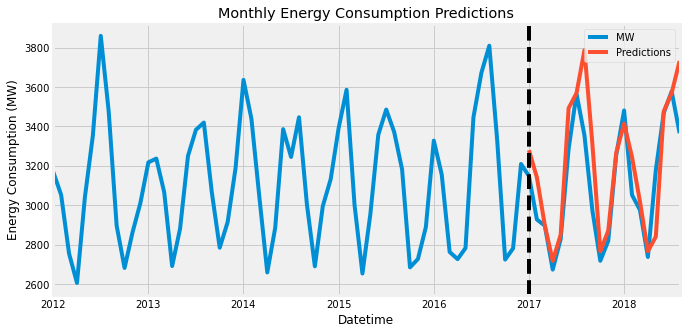

In [52]:
monthly_df = monthly_df1.merge(predictions[['predicted_mean']], how='left', left_index=True, right_index=True)
monthly_df['Predictions'] = monthly_df['predicted_mean']
ax = monthly_df[['MW']].plot(figsize=(10, 5))
monthly_df['Predictions'].plot(ax=ax)
plt.legend(['True Data', 'Predictions'])
ax.set_title('Monthly Energy Consumption Predictions')
plt.ylabel('Energy Consumption (MW)')
ax.axvline('01-01-2017', color = 'black', ls = '--')
plt.legend(loc='upper right')
plt.show()

# Evaluating the Model

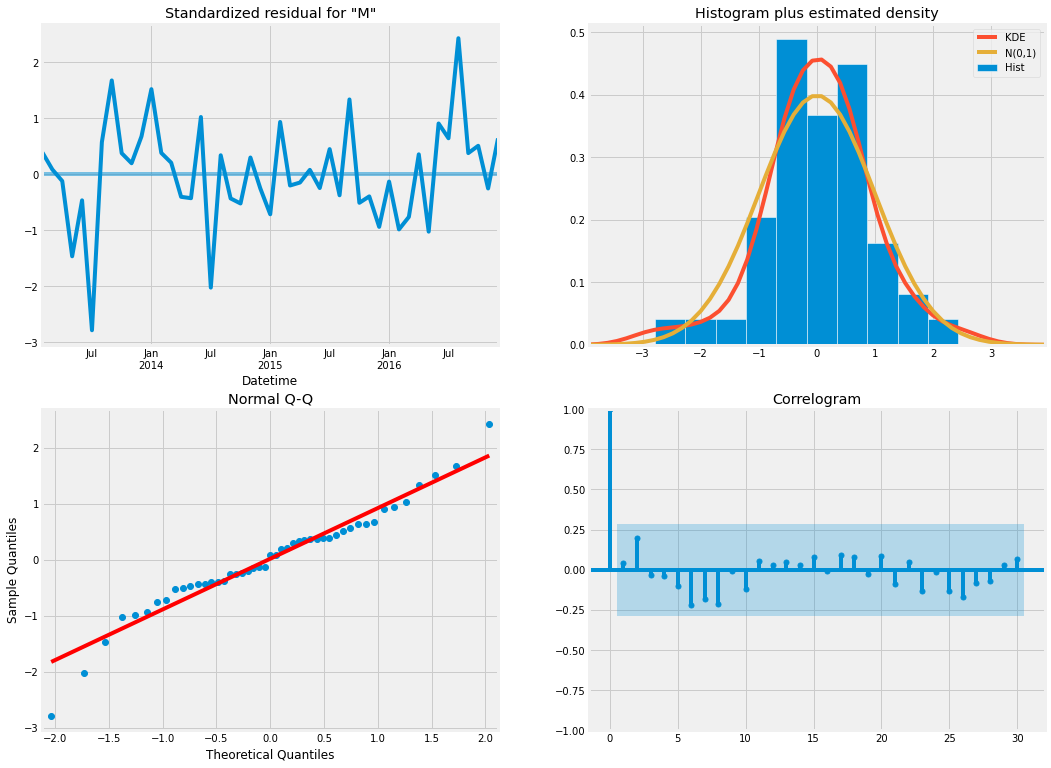

In [53]:
# Define default figure size
fig = plt.figure(figsize=(16,13))
# Use plot_predict and visualize forecasts
fig = model_fit.plot_diagnostics(fig=fig, lags=30)

# Statistical Measures

In [54]:
MSE = mean_squared_error(predictions, y_test)
print(f'MSE Score on Test set: {MSE:0.2f}')

MSE Score on Test set: 35435.13


In [55]:
RMSE = np.sqrt(mean_squared_error(predictions, y_test))
print(f'RMSE Score on Test set: {RMSE:0.2f}')

RMSE Score on Test set: 188.24


In [56]:
MAE = mean_absolute_error(predictions, y_test)
print(f'MAE Score on Test set: {MAE:0.2f}')

MAE Score on Test set: 127.97


In [59]:
MAPE = mean_absolute_percentage_error(predictions, y_test)
print(f'MAPE Score on Test set: {MAPE:0.3f}')

MAPE Score on Test set: 0.039


# Calculate Error
- Look at the worst and best predicted days

### Dates Predicted with Lowest Absolute Error

In [24]:
y_test = pd.DataFrame(y_test)
y_test['error'] = np.abs(y_test['MW'] - predictions['predicted_mean'])
y_test['date'] = y_test.index
y_test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)


date
2017-03-31     2.071805
2017-07-31     2.963003
2018-06-30     8.002888
2018-07-31     8.007340
2017-12-31    11.797062
2017-05-31    22.449024
2018-04-30    29.065450
2018-03-31    42.828294
2017-04-30    44.008668
2017-10-31    48.017491
Name: error, dtype: float64

### Dates Predicted with Highest Absolute Error

In [25]:
y_test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-08-31    432.608673
2018-08-31    366.539984
2017-09-30    338.439404
2018-05-31    338.321965
2017-02-28    214.011121
2017-06-30    207.700411
2018-02-28    192.788008
2017-01-31    131.445007
2018-01-31     66.706171
2017-11-30     51.546245
Name: error, dtype: float64